[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/danielmlow/llm_course/blob/main/embeddings_tutorial.ipynb)

# Embeddings Tutorial: Encoding, Dimensionality Reduction, and Clustering

This tutorial will guide you through the complete process of:
1. **Ecoding Embeddings** using transformer models
2. **Dimensionality reduction** with UMAP
3. **Clustering** vector representations
4. **Visualizing** the results

We will use sentences about different social constructs to demonstrate how embeddings capture semantic meaning.


In [1]:
# Install dependencies
# Run this cell if you don't have the libraries installed
!pip install -q sentence-transformers umap-learn plotly
!pip install -q nbformat


In [2]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
import umap
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

# Configure visualization style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")


## 1. Data: Sentences About Social Constructs

We will create a set of sentences that address different social constructs. This will allow us to see how embeddings capture semantic similarities between related concepts.


In [3]:
# Define sentences about different social constructs
sentences = {
    'Cultural Identity': [
        "Cultural identity is formed through family traditions",
        "Ancestral customs shape our cultural identity",
        "Folk music is a fundamental part of cultural identity",
        "Traditional celebrations strengthen cultural identity",
        "Mother tongue is a pillar of cultural identity"
    ],
    
    'Social Inequality': [
        "Social inequality affects access to education",
        "Economic differences generate social inequality",
        "Social mobility is limited by inequality",
        "Social inequality impacts community health",
        "Education systems can perpetuate social inequality"
    ],
    
    'Migration': [
        "Migration is a global phenomenon that connects cultures",
        "Migrants contribute to the economic development of countries",
        "Migration generates cultural diversity in societies",
        "Migration processes require integration policies",
        "Migration can be motivated by conflicts or opportunities"
    ],
    
    'Gender': [
        "Gender equality is fundamental for social development",
        "Gender stereotypes limit people's opportunities",
        "Gender perspective must be included in public policies",
        "Gender violence is a structural problem in society",
        "Women's political participation strengthens democracy"
    ],
    
    'Environment': [
        "Climate change affects all communities in the world",
        "Environmental sustainability requires changes in our habits",
        "Environmental pollution impacts population health",
        "Renewable energies are key to a sustainable future",
        "Biodiversity conservation is everyone's responsibility"
    ],
    
    'Technology': [
        "Digital technology transforms the way we communicate",
        "Artificial intelligence is changing the world of work",
        "Social media influences interpersonal relationships",
        "The digital divide excludes sectors of the population",
        "Technology can democratize access to knowledge"
    ]
}

# Create DataFrame with sentences
data = []
for category, category_sentences in sentences.items():
    for sentence in category_sentences:
        data.append({
            'category': category,
            'sentence': sentence,
            'length': len(sentence.split())
        })

df = pd.DataFrame(data)
print(f"Total sentences: {len(df)}")
print(f"Categories: {df['category'].unique()}")
print("\nFirst 5 sentences:")
print(df.head())


Total sentences: 30
Categories: ['Cultural Identity' 'Social Inequality' 'Migration' 'Gender'
 'Environment' 'Technology']

First 5 sentences:
            category                                           sentence  \
0  Cultural Identity  Cultural identity is formed through family tra...   
1  Cultural Identity      Ancestral customs shape our cultural identity   
2  Cultural Identity  Folk music is a fundamental part of cultural i...   
3  Cultural Identity  Traditional celebrations strengthen cultural i...   
4  Cultural Identity     Mother tongue is a pillar of cultural identity   

   length  
0       7  
1       6  
2       9  
3       5  
4       8  


## 2. Generating Embeddings

Embeddings are dense vector representations that capture the semantic meaning of text. We will use a Sentence Transformers model optimized for multilingual text.


In [4]:
# Load embeddings model
# This model is optimized for multiple languages including English
model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')

print("Model loaded successfully")
print(f"Embedding dimensions: {model.get_sentence_embedding_dimension()}")


Model loaded successfully
Embedding dimensions: 384


In [5]:
# Generate embeddings for all sentences
print("Generating embeddings...")
embeddings = model.encode(df['sentence'].tolist(), show_progress_bar=True)

print(f"Embeddings shape: {embeddings.shape}")
print(f"Data type: {embeddings.dtype}")

# Save embeddings in the DataFrame
df['embedding'] = list(embeddings)

# Show basic statistics
print(f"\nEmbedding statistics:")
print(f"Minimum value: {embeddings.min():.4f}")
print(f"Maximum value: {embeddings.max():.4f}")
print(f"Average value: {embeddings.mean():.4f}")
print(f"Standard deviation: {embeddings.std():.4f}")


Generating embeddings...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Embeddings shape: (30, 384)
Data type: float32

Embedding statistics:
Minimum value: -1.0225
Maximum value: 1.0811
Average value: 0.0000
Standard deviation: 0.2635


## 3. Dimensionality Reduction with UMAP

UMAP (Uniform Manifold Approximation and Projection) is a dimensionality reduction technique that preserves both the local and global structure of data. It is especially useful for visualizing high-dimensional embeddings.


In [6]:
# Configure and apply UMAP
print("Applying dimensionality reduction with UMAP...")

# UMAP parameters
n_neighbors = 15  # Number of neighbors for local structure
min_dist = 0.1    # Minimum distance between points
n_components = 2  # Output dimensions

# Create and fit the UMAP model
reducer = umap.UMAP(
    n_neighbors=n_neighbors,
    min_dist=min_dist,
    n_components=n_components,
    random_state=42,
    metric='cosine'  # Use cosine similarity for text embeddings
)

# Apply dimensionality reduction
embeddings_2d = reducer.fit_transform(embeddings)

print(f"Original shape: {embeddings.shape}")
print(f"Reduced shape: {embeddings_2d.shape}")

# Add 2D coordinates to DataFrame
df['x'] = embeddings_2d[:, 0]
df['y'] = embeddings_2d[:, 1]

print("\n2D coordinates generated successfully")


Applying dimensionality reduction with UMAP...


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Original shape: (30, 384)
Reduced shape: (30, 2)

2D coordinates generated successfully


## 4. Visualizations and Analysis

We will create interactive visualizations to explore the clustering and dimensionality reduction results.


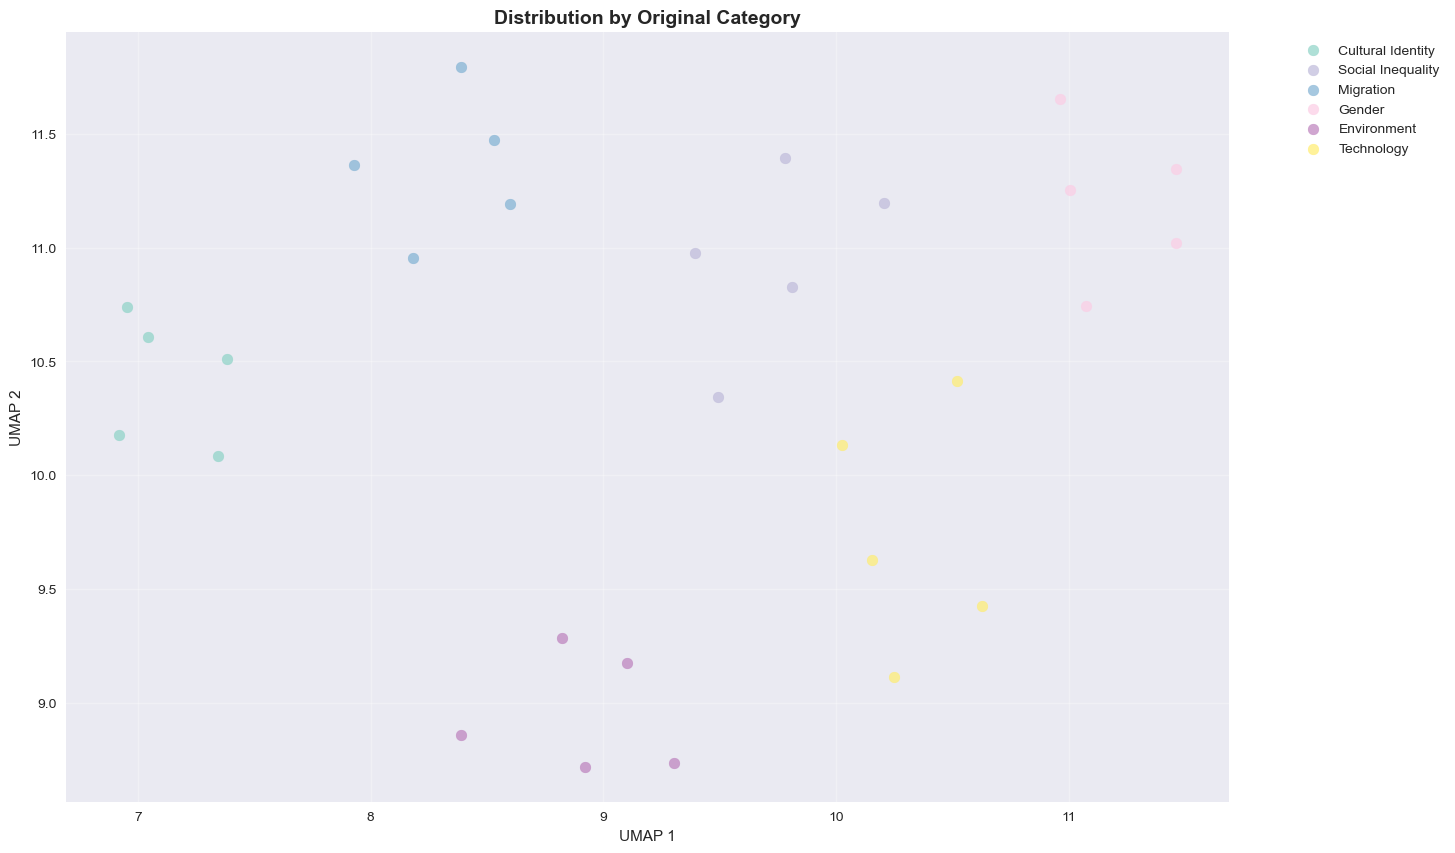

In [7]:
# Visualization with matplotlib
plt.figure(figsize=(15, 10))

# Plot: Clusters by original category

categories = df['category'].unique()
colors = plt.cm.Set3(np.linspace(0, 1, len(categories)))

for i, category in enumerate(categories):
    mask = df['category'] == category
    plt.scatter(df.loc[mask, 'x'], df.loc[mask, 'y'], 
               c=[colors[i]], label=category, alpha=0.7, s=60)

plt.title('Distribution by Original Category', fontsize=14, fontweight='bold')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)




In [8]:
# Interactive visualization with Plotly - Original categories only
fig = go.Figure()

# Plot by original category
for category in df['category'].unique():
    mask = df['category'] == category
    fig.add_trace(
        go.Scatter(
            x=df.loc[mask, 'x'],
            y=df.loc[mask, 'y'],
            mode='markers',
            name=category,
            text=df.loc[mask, 'sentence'],
            hovertemplate='<b>%{text}</b><br>Category: ' + category + '<extra></extra>',
            marker=dict(size=10, opacity=0.8)
        )
    )

# Update layout
fig.update_layout(
    title="Embeddings Visualization by Original Category",
    title_x=0.5,
    height=600,
    width=800,
    showlegend=True,
    xaxis_title="UMAP 1",
    yaxis_title="UMAP 2"
)

# Show figure
fig.show()


## 5. Semantic Similarity Analysis

Let's explore semantic similarities between sentences using the generated embeddings.


In [9]:
# Calculate cosine similarity matrix
from sklearn.metrics.pairwise import cosine_similarity

print("Calculating cosine similarity matrix...")
similarity_matrix = cosine_similarity(embeddings)

# Create DataFrame with similarity matrix
df_similarity = pd.DataFrame(
    similarity_matrix,
    index=df['sentence'],
    columns=df['sentence']
)

print(f"Similarity matrix shape: {similarity_matrix.shape}")

# Find most similar sentences for each sentence
print("\n=== MOST SIMILAR SENTENCES ===")
for i, sentence in enumerate(df['sentence']):
    # Get similarities (excluding the sentence with itself)
    similarities = similarity_matrix[i]
    similar_indices = np.argsort(similarities)[::-1][1:4]  # Top 3 most similar
    
    print(f"\nSentence: {sentence}")
    print("Most similar:")
    for j, idx in enumerate(similar_indices):
        similarity = similarities[idx]
        print(f"  {j+1}. {df.iloc[idx]['sentence']} (similarity: {similarity:.3f})")
    
    if i >= 2:  # Show only first 3 to avoid clutter
        print("\n... (showing only the first 3 sentences)")
        break


Calculating cosine similarity matrix...
Similarity matrix shape: (30, 30)

=== MOST SIMILAR SENTENCES ===

Sentence: Cultural identity is formed through family traditions
Most similar:
  1. Ancestral customs shape our cultural identity (similarity: 0.754)
  2. Mother tongue is a pillar of cultural identity (similarity: 0.686)
  3. Traditional celebrations strengthen cultural identity (similarity: 0.682)

Sentence: Ancestral customs shape our cultural identity
Most similar:
  1. Cultural identity is formed through family traditions (similarity: 0.754)
  2. Traditional celebrations strengthen cultural identity (similarity: 0.712)
  3. Mother tongue is a pillar of cultural identity (similarity: 0.645)

Sentence: Folk music is a fundamental part of cultural identity
Most similar:
  1. Ancestral customs shape our cultural identity (similarity: 0.631)
  2. Cultural identity is formed through family traditions (similarity: 0.591)
  3. Mother tongue is a pillar of cultural identity (similarity

## 7. Conclusions and Applications

### What have we learned?

1. **Semantic Embeddings**: Transformer models can capture the semantic meaning of text, representing it as dense high-dimensional vectors.

2. **Dimensionality Reduction**: UMAP is effective for visualizing embeddings while preserving both local and global data structure.

3. **Semantic Similarity**: Cosine similarity between embeddings reflects semantic relationships between sentences.

### Practical Applications

- **Sentiment Analysis**: Automatically classify opinions or comments
- **Semantic Search**: Find similar documents based on meaning, not just keywords
- **Topic Detection**: Automatically identify themes in large text corpora
- **Content Recommendation**: Suggest similar articles or posts
- **Social Media Analysis**: Group conversations by topics


## 8. Additional Exercises

### To Practice More:

1. **Experiment with different models**:
   ```python
   # Try other embedding models
   alternative_model = SentenceTransformer('all-MiniLM-L6-v2')
   ```

2. **Adjust UMAP parameters**:
   - Change `n_neighbors` (5, 10, 20, 50)
   - Modify `min_dist` (0.01, 0.1, 0.5, 1.0)
   - Observe how visualizations change

3. **Add more sentences**:
   - Include new thematic categories
   - Experiment with longer or shorter sentences
   - Try more technical or colloquial text

4. **Quality analysis**:
   - Calculate metrics like silhouette coefficient
   - Compare with hierarchical clustering
   - Evaluate semantic coherence of clusters


## 9. Additional Resources

### Documentation and Tutorials:
- [Sentence Transformers Documentation](https://www.sbert.net/)
- [UMAP Documentation](https://umap-learn.readthedocs.io/)
- [Scikit-learn Clustering](https://scikit-learn.org/stable/modules/clustering.html)

### Embedding Models:
- `paraphrase-multilingual-MiniLM-L12-v2` (used in this tutorial)
- `all-MiniLM-L6-v2` (English-optimized, faster)
- `all-mpnet-base-v2` (English, higher quality)
- `multi-qa-MiniLM-L6-cos-v1` (for question-answering)

### Related Tools:
- **spaCy**: Natural language processing
- **Transformers**: Hugging Face library
- **Gensim**: Topic modeling and word2vec
- **BERTopic**: Topic clustering with BERT

---


